# Libraries

In [1]:
# tensorflow utils
import tensorflow as tf

# matplotlib utils
import matplotlib as mpl
import matplotlib.pyplot as plt

# other utils
import numpy as np
import pandas as pd
import seaborn as sn

# Datasets

In [2]:
( (p_images, p_labels),
  (q_images, q_labels), ) = tf.keras.datasets.fashion_mnist.load_data()

# normalize
p_images = p_images / 255.0
q_images = q_images / 255.0

# Noises

In [3]:
class CauchyNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, amplify: float, clip=(0, 1)):
        super(CauchyNoiseLayer, self).__init__()
        self.clip = clip
        self.amplify = amplify

    def call(self, inputs, training=None):
        r1 = tf.random.normal(shape=tf.shape(inputs), mean=0, stddev=1)
        r2 = tf.random.normal(shape=tf.shape(inputs), mean=0, stddev=1)
        return tf.clip_by_value(inputs + self.amplify*(r1 / r2), self.clip[0], self.clip[1])

class NormalNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, mean: float, stddev: float, clip=(0, 1)):
        super(NormalNoiseLayer, self).__init__()
        self.clip = clip
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs, training=None):
        noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
        return tf.clip_by_value(inputs + noise, self.clip[0], self.clip[1])

class UniformNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, minval: float, maxval: float, clip=(0, 1)):
        super(UniformNoiseLayer, self).__init__()
        self.clip = clip
        self.minval = minval
        self.maxval = maxval
        
    def call(self, inputs, training=None):
        noise = tf.random.uniform(shape=tf.shape(inputs), minval=self.minval, maxval=self.maxval)
        return tf.clip_by_value(inputs + noise, self.clip[0], self.clip[1])

# Model

In [4]:
model = tf.keras.models.load_model('../models/model.fashion_mnist.keras')

# Test :: without noise

In [5]:
# evaluation
p_eval = model.evaluate(p_images, p_labels)
q_eval = model.evaluate(q_images, q_labels)

# prediction
p_pred = model.predict(p_images).argmax(-1)
q_pred = model.predict(q_images).argmax(-1)

# confusion
p_conf = tf.math.confusion_matrix(p_labels, p_pred)
q_conf = tf.math.confusion_matrix(q_labels, q_pred)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 602us/step - accuracy: 0.8965 - loss: 0.2783
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - accuracy: 0.8780 - loss: 0.3421
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


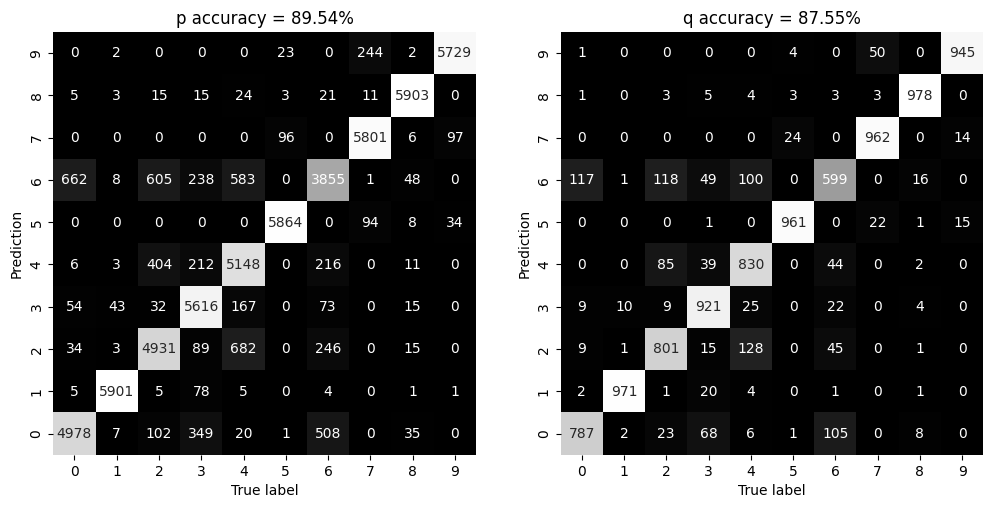

In [6]:
plt.figure(figsize=(12, 8))

# visualize p confusion matrix
plt.subplot(1, 2, 1)
sn.heatmap(pd.DataFrame(p_conf), annot=True, cbar=False, cmap='gist_gray', fmt='g', square=True).invert_yaxis()
plt.title(f'p accuracy = {p_eval[1]:.2%}')
plt.xlabel('True label')
plt.ylabel('Prediction')

# visualize q confusion matrix
plt.subplot(1, 2, 2)
sn.heatmap(pd.DataFrame(q_conf), annot=True, cbar=False, cmap='gist_gray', fmt='g', square=True).invert_yaxis()
plt.title(f'q accuracy = {q_eval[1]:.2%}')
plt.xlabel('True label')
plt.ylabel('Prediction')

plt.show()

# Test :: with Cauchy noise

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - accuracy: 0.8780 - loss: 0.3421
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step


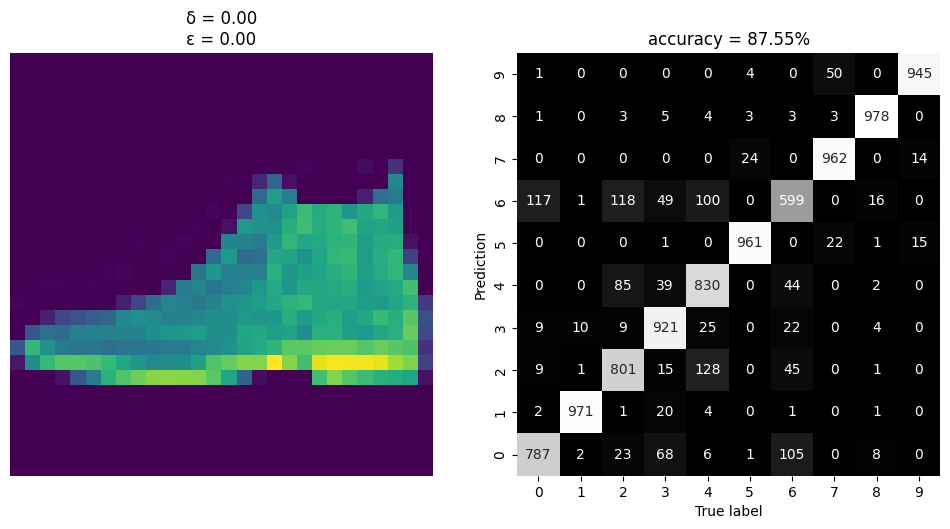

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.8755 - loss: 0.3466
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step


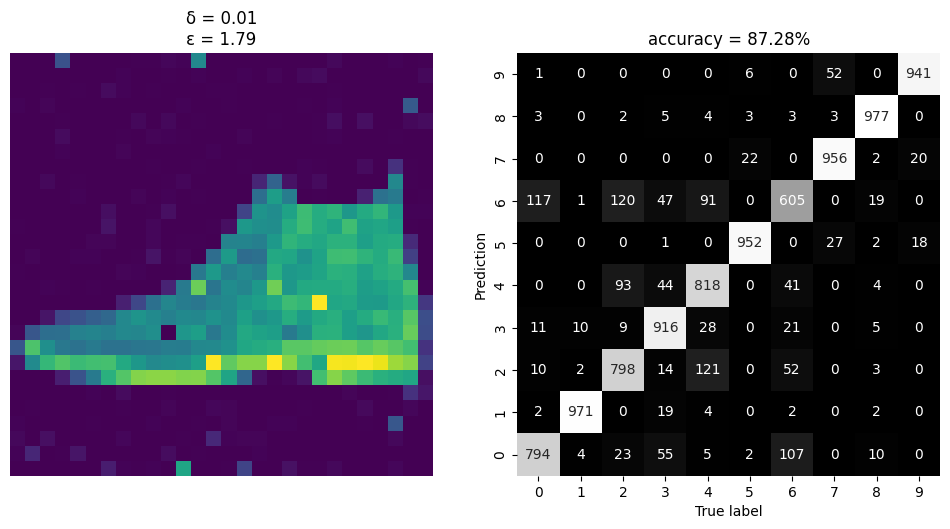

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.8713 - loss: 0.3591
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step


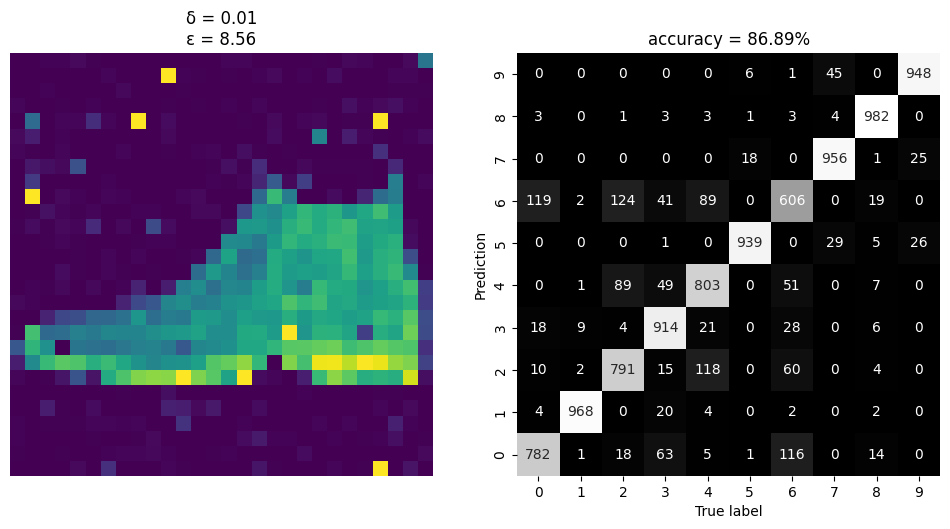

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.8614 - loss: 0.3780
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step


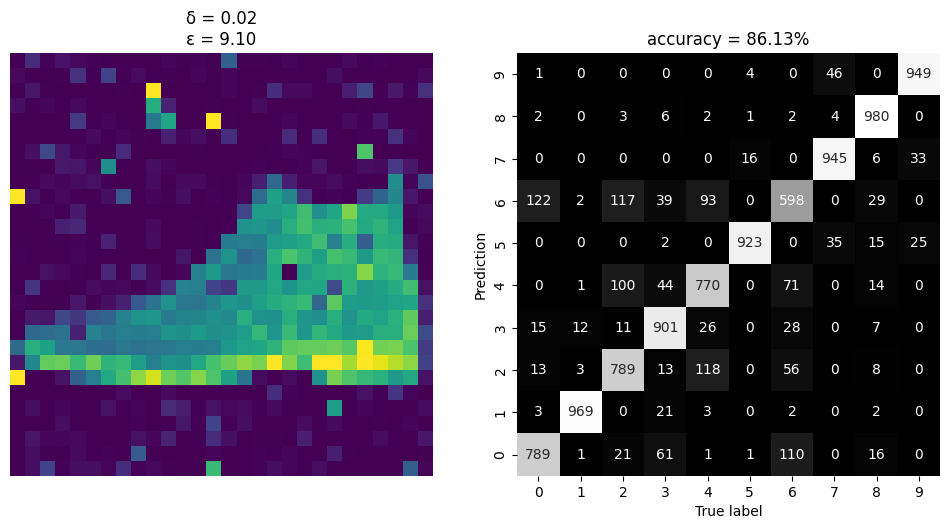

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - accuracy: 0.8215 - loss: 0.5086
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step


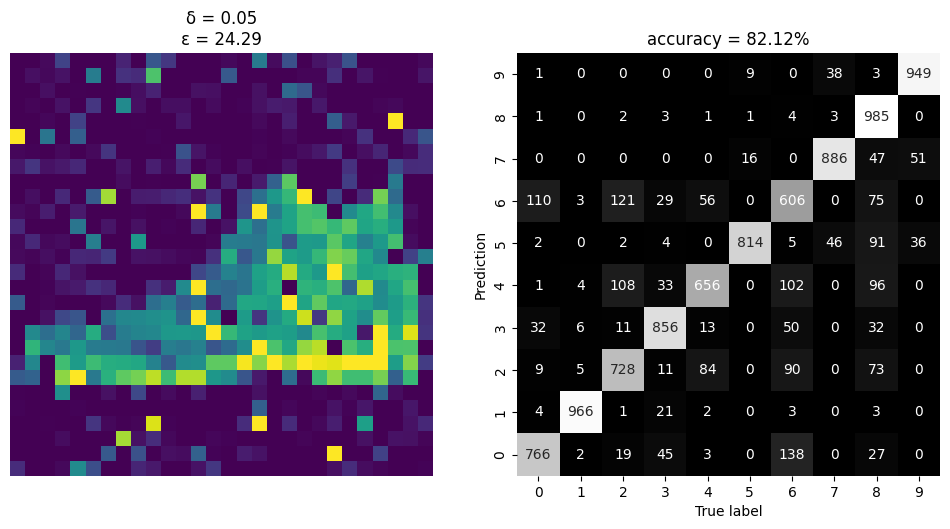

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.6681 - loss: 0.9181
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step


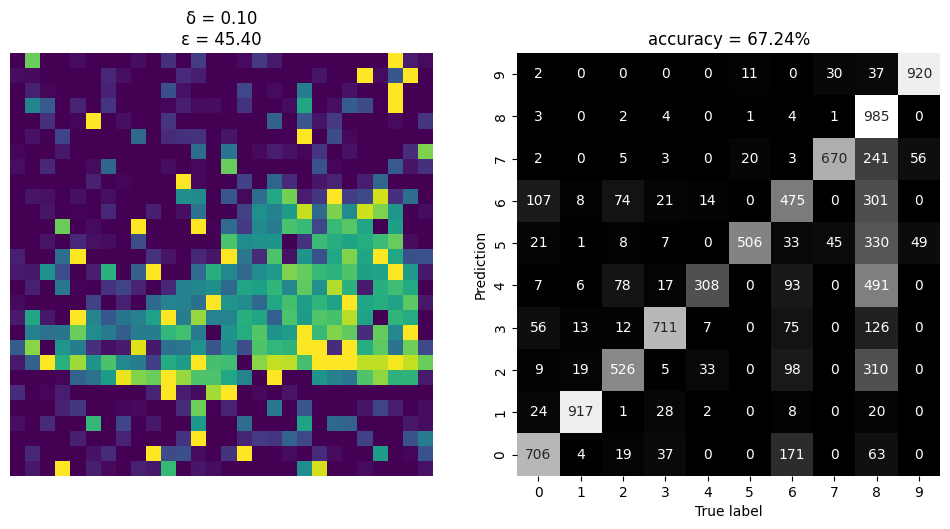

In [7]:
for noise_level in (0, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1):
    q_noised = CauchyNoiseLayer(amplify=noise_level)(q_images)

    # evaluation
    q_eval = model.evaluate(q_noised, q_labels)

    # prediction
    q_pred = model.predict(q_noised).argmax(-1)

    # confusion
    q_conf = tf.math.confusion_matrix(q_labels, q_pred)

    plt.figure(figsize=(12, 8))

    # visualize noised digit
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(f'δ = {noise_level:.2f}\nε = {((q_images[0] - q_noised[0]) ** 2).numpy().sum():.2f}')
    plt.imshow(q_noised[0])

    # visualize confusion matrix
    plt.subplot(1, 2, 2)
    sn.heatmap(pd.DataFrame(q_conf), annot=True, cbar=False, cmap='gist_gray', fmt='g', square=True).invert_yaxis()
    plt.title(f'accuracy = {q_eval[1]:.2%}')
    plt.xlabel('True label')
    plt.ylabel('Prediction')

    plt.show()

# Test :: with Normal noise

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.8780 - loss: 0.3421
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step


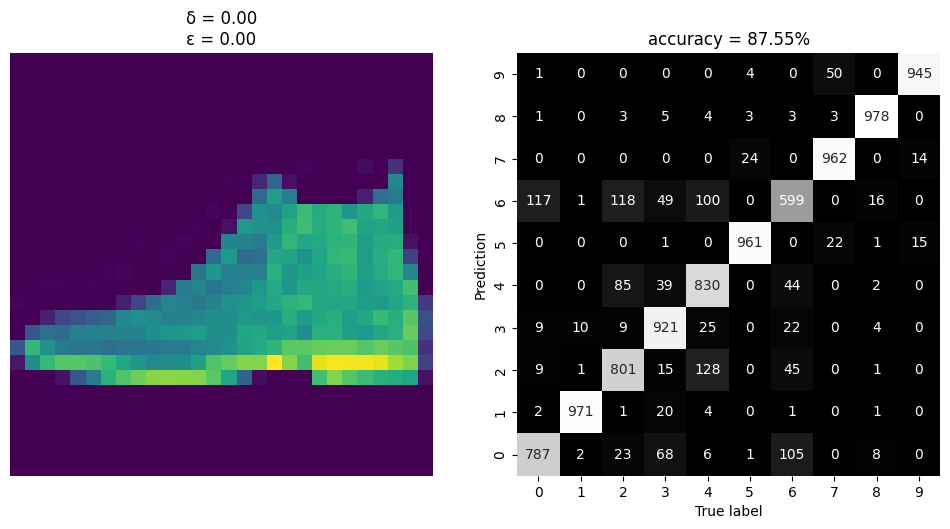

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - accuracy: 0.8639 - loss: 0.3876
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step


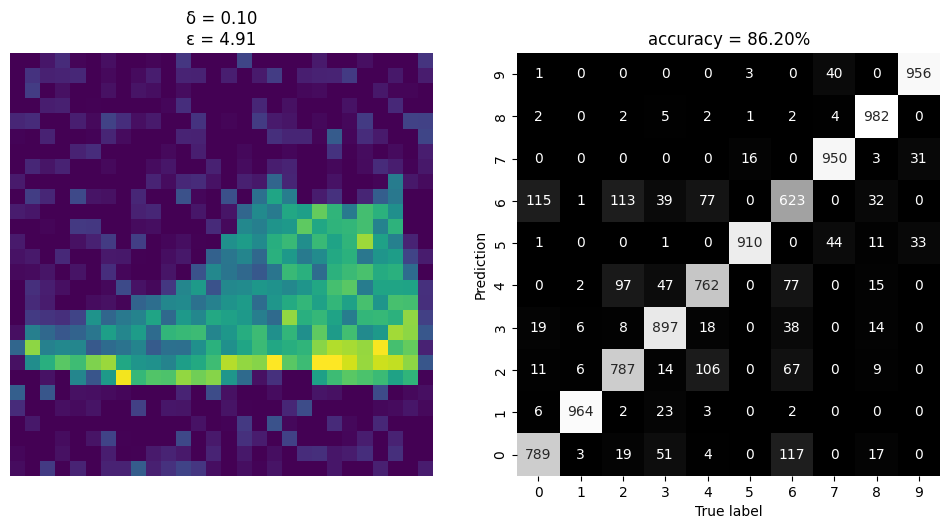

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.8362 - loss: 0.4622
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step


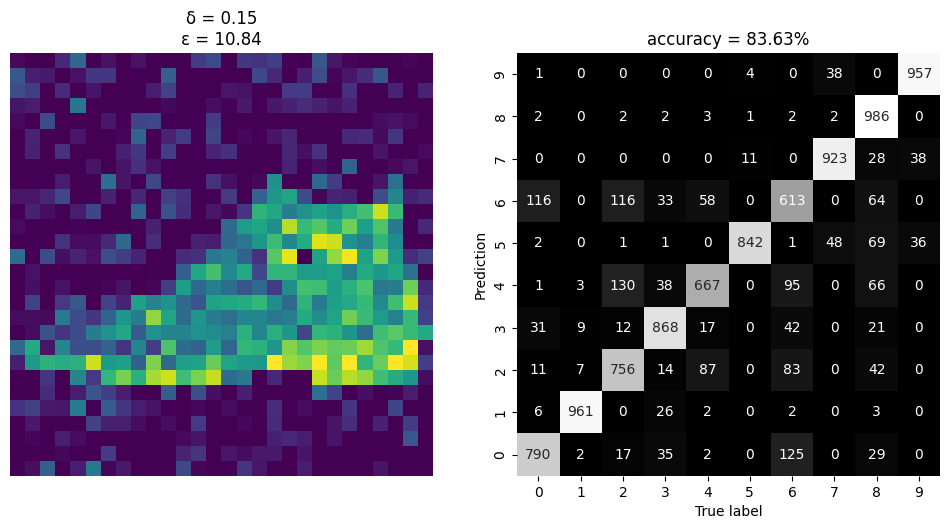

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.7808 - loss: 0.6073
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step


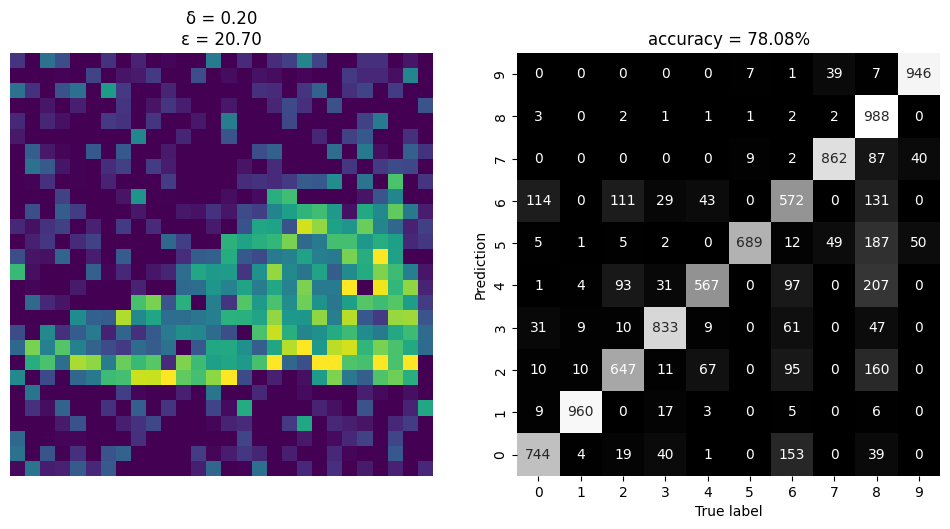

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.6985 - loss: 0.8040
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step


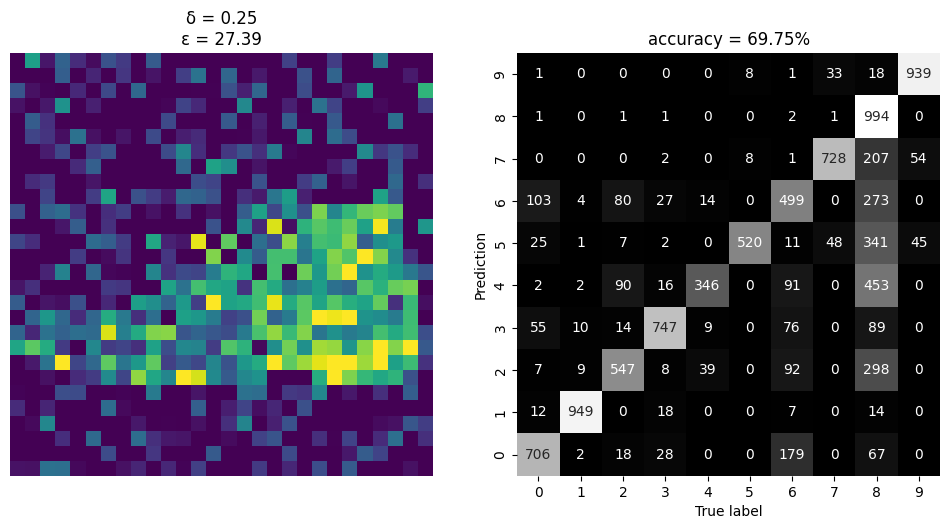

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.5999 - loss: 1.0749
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step


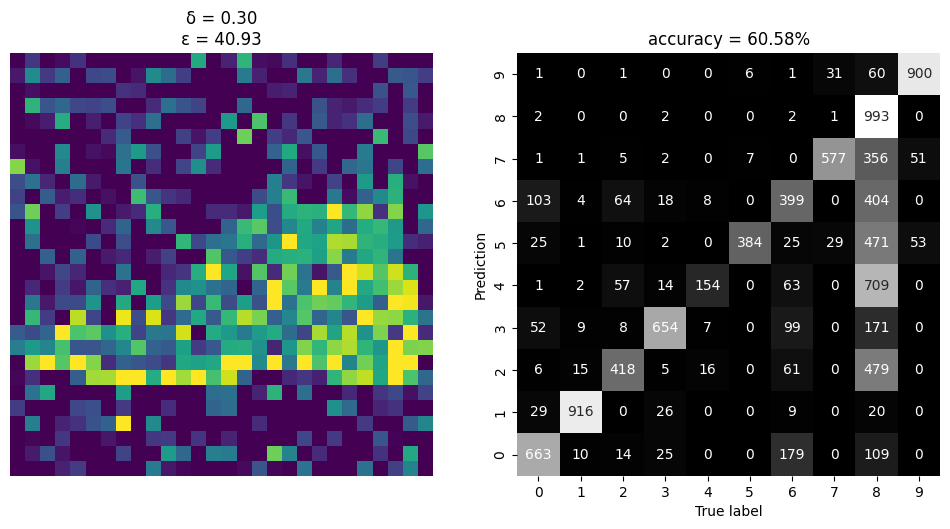

In [8]:
for noise_level in (0, 1e-1, 1.5e-1, 2e-1, 2.5e-1, 3e-1):
    q_noised = NormalNoiseLayer(mean=0, stddev=noise_level)(q_images)

    # evaluation
    q_eval = model.evaluate(q_noised, q_labels)

    # prediction
    q_pred = model.predict(q_noised).argmax(-1)

    # confusion
    q_conf = tf.math.confusion_matrix(q_labels, q_pred)

    plt.figure(figsize=(12, 8))

    # visualize noised digit
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(f'δ = {noise_level:.2f}\nε = {((q_images[0] - q_noised[0]) ** 2).numpy().sum():.2f}')
    plt.imshow(q_noised[0])

    # visualize confusion matrix
    plt.subplot(1, 2, 2)
    sn.heatmap(pd.DataFrame(q_conf), annot=True, cbar=False, cmap='gist_gray', fmt='g', square=True).invert_yaxis()
    plt.title(f'accuracy = {q_eval[1]:.2%}')
    plt.xlabel('True label')
    plt.ylabel('Prediction')

    plt.show()

# Test :: with Uniform noise

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.8780 - loss: 0.3421
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step


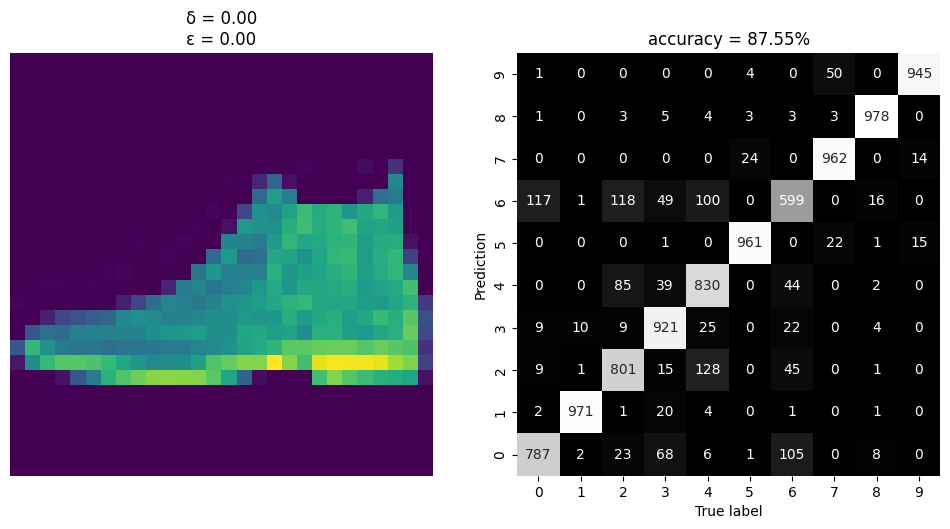

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.8693 - loss: 0.3538
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step


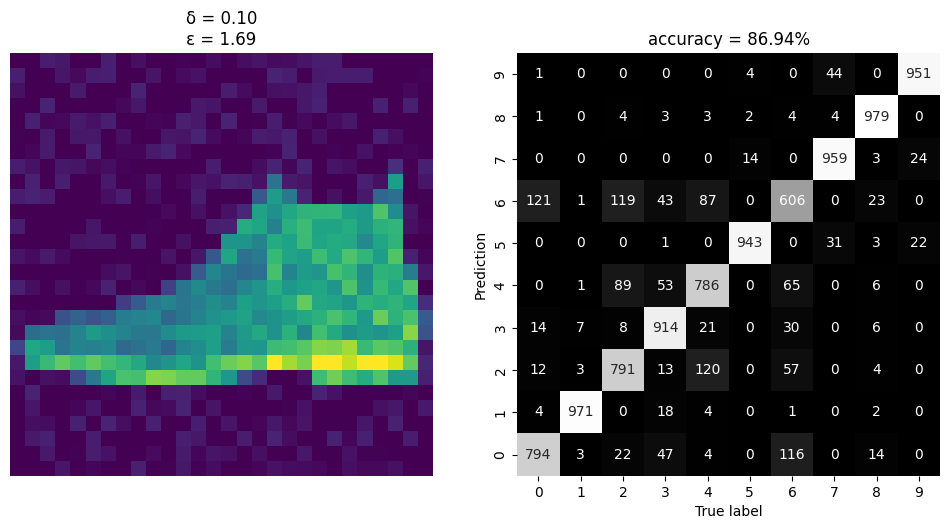

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.8572 - loss: 0.4112
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step


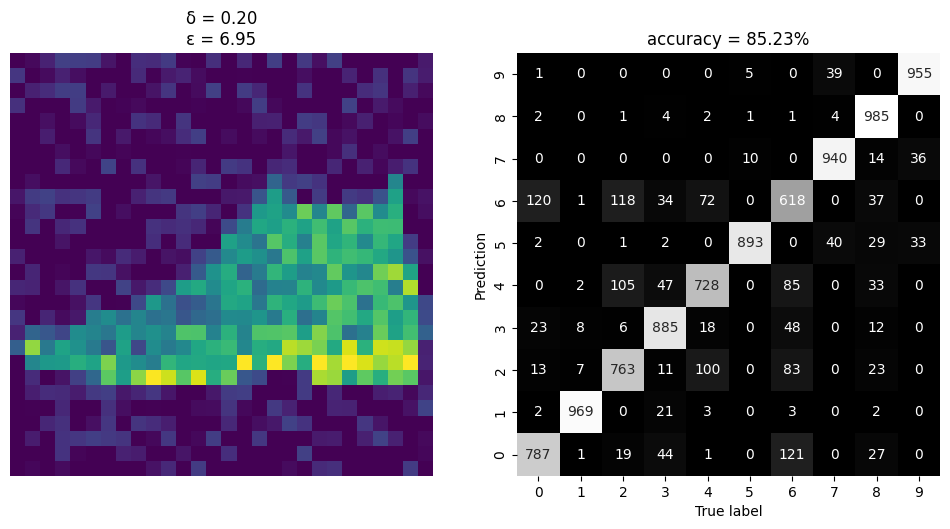

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.8014 - loss: 0.5472
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step


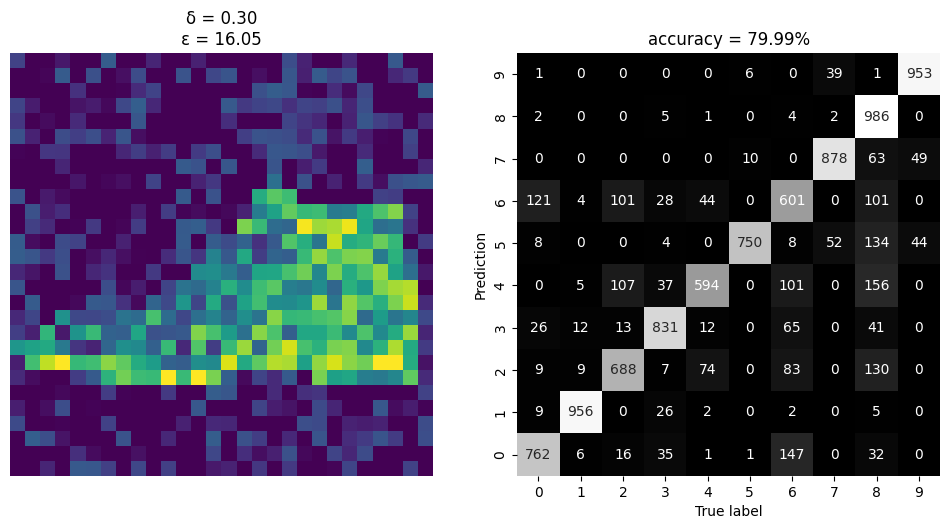

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.7008 - loss: 0.7901
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step


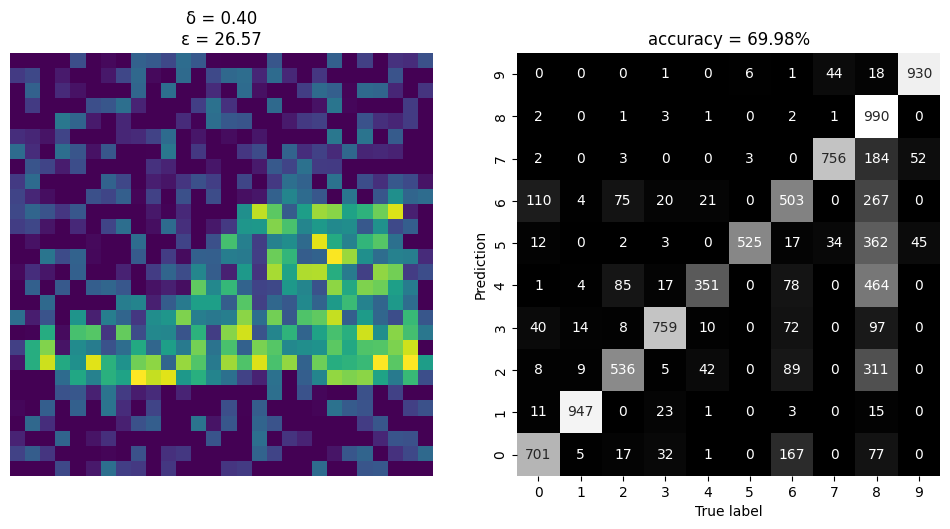

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - accuracy: 0.5762 - loss: 1.1487
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


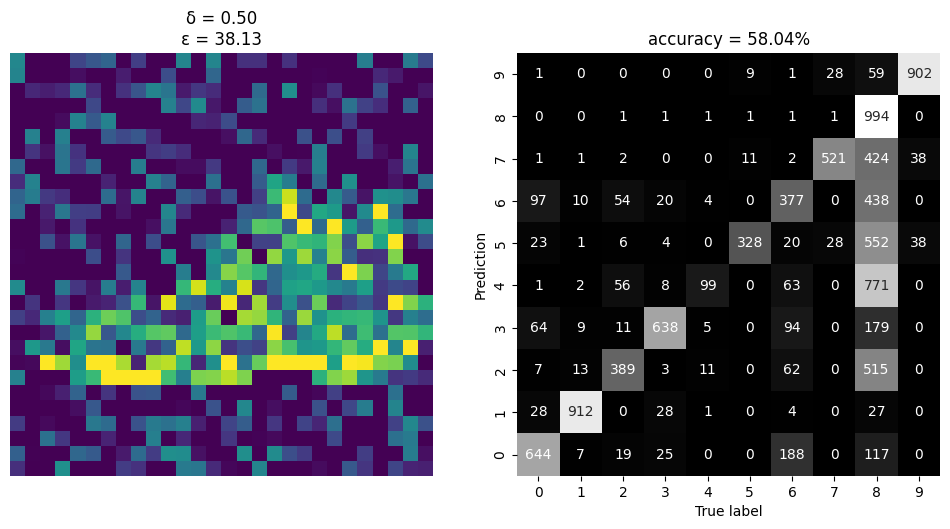

In [9]:
for noise_level in (0, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1):
    q_noised = UniformNoiseLayer(minval=-noise_level, maxval=+noise_level)(q_images)

    # evaluation
    q_eval = model.evaluate(q_noised, q_labels)

    # prediction
    q_pred = model.predict(q_noised).argmax(-1)

    # confusion
    q_conf = tf.math.confusion_matrix(q_labels, q_pred)

    plt.figure(figsize=(12, 8))

    # visualize noised digit
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(f'δ = {noise_level:.2f}\nε = {((q_images[0] - q_noised[0]) ** 2).numpy().sum():.2f}')
    plt.imshow(q_noised[0])

    # visualize confusion matrix
    plt.subplot(1, 2, 2)
    sn.heatmap(pd.DataFrame(q_conf), annot=True, cbar=False, cmap='gist_gray', fmt='g', square=True).invert_yaxis()
    plt.title(f'accuracy = {q_eval[1]:.2%}')
    plt.xlabel('True label')
    plt.ylabel('Prediction')

    plt.show()